### Récupération des bibliothèques essentielles

In [4]:
import os
import requests
import json
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
from PIL.ExifTags import TAGS
from io import BytesIO

### Pull de 100 oeuvres d'art (formats png, jpeg, etc.) depuis Wikidata

In [ ]:
import os
import sys
import json
import requests
from io import BytesIO
from PIL import Image
from SPARQLWrapper import SPARQLWrapper, JSON

# Crée le dossier pour les images si ce n'est pas déjà fait
def create_images_folder():
    if not os.path.exists("images"):
        os.makedirs("images")
        print("Dossier 'images' créé.")

# Effectue une requête pour récupérer les données depuis Wikidata
def get_wikidata_datas(query):
    endpoint_url = "https://query.wikidata.org/sparql"
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


# Télécharge les images depuis Wikidata et récupère leurs métadonnées
def download_images_from_wikidata(num_images=100):
    query = """
    SELECT DISTINCT ?item ?pic WHERE {
      ?item wdt:P31 wd:Q3305213;
            wdt:P18 ?pic.
    }
    LIMIT 100 OFFSET 300
    """
    
    results = get_wikidata_datas(query)
    image_data = []
    
    for result in results["results"]["bindings"]:
        image_data.append({
            "item": result["item"]["value"].split("/")[-1],  # Récupérer l'ID Qxxxxx
            "pic": result["pic"]["value"]
        })
    
    # Récupérer les hashtags depuis Wikidata
    qids = " ".join(f"wd:{data['item']}" for data in image_data)
    tag_query = f"""
    SELECT DISTINCT ?item ?title ?artistLabel ?movementLabel ?materialLabel ?locationLabel ?depictsLabel ?countryLabel WHERE {{
      VALUES ?item {{ {qids} }}
      OPTIONAL {{ ?item wdt:P1476 ?title. }}
      OPTIONAL {{ ?item wdt:P170 ?artist. }}
      OPTIONAL {{ ?item wdt:P135 ?movement. }}
      OPTIONAL {{ ?item wdt:P186 ?material. }}
      OPTIONAL {{ ?item wdt:P276 ?location. }}
      OPTIONAL {{ ?item wdt:P180 ?depicts. }}
      OPTIONAL {{ ?item wdt:P495 ?country. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "fr,en". }}
    }}
    """
    
    tag_results = get_wikidata_datas(tag_query)
    tags_dict = {}
    
    for result in tag_results["results"]["bindings"]:
        item_id = result["item"]["value"].split("/")[-1]
        tags = []
        
        for key in ["title", "artistLabel", "movementLabel", "materialLabel", "locationLabel", "depictsLabel", "countryLabel"]:
            if key in result:
                tags.append("#" + result[key]["value"].replace(" ", "_"))
        
        tags_dict[item_id] = tags
    
    # Télécharger les images et ajouter les métadonnées
    downloaded_images = []
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    for idx, data in enumerate(image_data[:num_images]):
        try:
            img_response = requests.get(data["pic"], headers=headers)
            img = Image.open(BytesIO(img_response.content))
            extension = img.format.lower()
            filename = f"images/image_{idx}.{extension}"
            img.save(filename)
            
            # Récupérer les hashtags depuis tags_dict
            tags = tags_dict.get(data["item"], [])
            
            # Récupérer les autres informations : orientation, taille, format
            img_width, img_height = img.size
            orientation = "Portrait" if img_height > img_width else "Paysage" if img_width > img_height else "Carré"
            metadata = {
                "filename": f"image_{idx}.{extension}",
                "tags": tags,
                "orientation": orientation,
                "size": [img_width, img_height],
                "format": extension,
            }
            
            # Sauvegarder les métadonnées dans le fichier
            save_metadata(metadata)
            
            downloaded_images.append(filename)
            print(f"Image enregistrée : {filename}")
        
        except Exception as e:
            print(f"Erreur lors du téléchargement de {data['pic']}: {e}")
    
    return downloaded_images

# Sauvegarde les métadonnées des images sous forme de tags dans un fichier JSON
def save_metadata(metadata, output_json="metadata.json"):
    try:
        # Ouvrir le fichier en mode append et vérifier si c'est la première image
        file_exists = os.path.exists(output_json)

        with open(output_json, "a", encoding="utf-8") as f:
            if not file_exists:
                f.write("[\n")  # Ajouter l'ouverture de la liste si c'est le premier élément
            else:
                f.write(",\n")  # Ajouter une virgule avant chaque nouvelle entrée
            json.dump(metadata, f, indent=4, ensure_ascii=False)
            f.write("\n")  # S'assurer que chaque objet est sur une nouvelle ligne
        print(f"Métadonnées enregistrées dans {output_json}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des métadonnées : {e}")

# Fonction principale : lancer le téléchargement et la sauvegarde des métadonnées
def main():
    create_images_folder()
    images = download_images_from_wikidata()
    if images:
        print(f"{len(images)} images téléchargées.")
    else:
        print("Aucune image téléchargée.")
    
    # Ajoute la fermeture du tableau JSON à la fin du fichier
    with open("metadata.json", "a", encoding="utf-8") as f:
        f.write("\n]")

if __name__ == "__main__":
    main()


Dossier 'images' créé.
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_0.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_1.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_2.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_3.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_4.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_5.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_6.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_7.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_8.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_9.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_10.png
Métadonnées enregistrées dans metadata.json
Image enr

/home/dev/.local/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (141250812 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_66.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_67.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_68.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_69.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_70.jpeg
Erreur lors du téléchargement de http://commons.wikimedia.org/wiki/Special:FilePath/Saint%20George%20and%20the%20princess%20by%20Pisanello%20-%20Pellegrini%20Chapel%20-%20Sant%27Anastasia%20-%20Verona%202016%20and%20corrections%20%28perspective%2C%20lights%2C%20definition%20by%20Paolo%20Villa%202019%29.jpg: Image size (226536844 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_72.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image

/home/dev/.local/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (175214016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_91.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_92.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_93.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_94.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_95.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_96.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_97.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_98.jpeg
Métadonnées enregistrées dans metadata.json
Image enregistrée : images/image_99.jpeg
98 images téléchargées.


### Récupération des couleurs prédominantes sur chaque image

In [3]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

def get_dominant_color(image_path, n_colors=3):
    try:
        # On vérifie si l'image est bien RGB
        img = Image.open(image_path).convert('RGB')
        
        # On redimensionne l'image pour accélérer le traitement
        img = img.resize((img.width // 10, img.height // 10))
        
        # L'image est convertie en tableau numpy
        img_array = np.array(img)
        
        # Construction d'un tableau où chaque ligne équivaut à 1 pixel
        pixels = img_array.reshape(-1, 3)
        
        # Utilisation de KMeans pour trouver les couleurs
        kmeans = KMeans(n_clusters=n_colors)
        kmeans.fit(pixels)
        
        # On récupère les couleurs
        dominant_colors = kmeans.cluster_centers_.astype(int)
        
        # Conversion des couleurs en héxadécimal
        dominant_colors_hex = [mcolors.rgb2hex(c / 255.0) for c in dominant_colors]
        
        return dominant_colors_hex
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        return []

def process_images_in_folder(folder_path, n_colors=3):
    dominant_colors_per_image = {}
    
    # On boucle sur les images présentent dans le dossier /images
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check si il s'agit bien d'une image (et pas d'un autre type de fichier)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Appel de la fonction pour déterminer les couleurs dominantes
                dominant_colors = get_dominant_color(file_path, n_colors)
                # Si la fonction détecte bien des couleurs
                if dominant_colors:
                    # Ajout au tableau des couleurs par images
                    dominant_colors_per_image[filename] = dominant_colors
            except Exception as e:
                print(f"Erreur lors du traitement de {filename}: {e}")
    
    return dominant_colors_per_image

def update_metadata_with_colors(metadata_path, folder_path, n_colors=3):
    try:
        # On charge les metadonnées existantes dans metadata.json
        with open(metadata_path, 'r', encoding='utf-8') as f:
            metadata = json.load(f)
    except Exception as e:
        print(f"Erreur lors du chargement de {metadata_path}: {e}")
        return

    # Appel de la fonction qui boucle sur toutes les images du dossier (et qui appel la fonction pour déterminer les couleurs dominantes)
    dominant_colors_per_image = process_images_in_folder(folder_path, n_colors)
    
    # On met à jour les metadonnées
    for entry in metadata:
        # Pour chaque image (= filename)
        if 'filename' in entry:
            filename = entry['filename']
            # Si des couleurs ont bien été trouvées pour cette image/file
            if filename in dominant_colors_per_image:
                # On ajoute le champ "colors" avec les couleurs associées.
                entry['colors'] = dominant_colors_per_image[filename]
        else:
            print(f"Entrée invalide sans 'filename' : {entry}")

    # Sauvegarder les métadonnées mises à jour dans le fichier
    try:
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)
        print(f"Les métadonnées ont été mises à jour avec les couleurs.")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des métadonnées : {e}")

def main():
    metadata_path = "metadata.json"  # Chemin vers le fichier metadata
    folder_path = "images"  # Dossier contenant les images
    
    # Check si le répertoire des images existe
    if not os.path.exists(folder_path):
        print(f"Le dossier '{folder_path}' n'existe pas. Vérifiez le chemin.")
        return
    
    # Check si le fichier des métadonnées existe
    if not os.path.exists(metadata_path):
        print(f"Le fichier '{metadata_path}' n'existe pas. Vérifiez le chemin.")
        return
    
    # Appel de la fonction racine pour lancer les programmes spécifiques (ouverture des images, association des couleurs et écriture dans le fichier metadata.json)
    update_metadata_with_colors(metadata_path, folder_path)
    
if __name__ == "__main__":
    main()


Les métadonnées ont été mises à jour avec les couleurs.


## Gestion des préférences utilisateur

Installer Tkinter: `sudo apt-get install python3-tk`

In [9]:
! pip install tk

Defaulting to user installation because normal site-packages is not writeable


In [27]:
import os
import json
import tkinter as tk
from tkinter import messagebox, simpledialog
from PIL import Image, ImageTk

class ImageAnnotator:
    def __init__(self, root, images):
        self.root = root
        self.root.title("Sélection des images préférées")
        self.images = images
        self.current_index = 0
        self.liked_images = {}  # Stocke les images likées avec leurs tags

        # Interface Tkinter
        self.image_label = tk.Label(root)
        self.image_label.pack(pady=10)

        self.selection_label = tk.Label(root, text="Sélectionne tes images préférées :", font=("Arial", 12))
        self.selection_label.pack()

        # Boutons de navigation
        self.prev_button = tk.Button(root, text="⏪ Précédent", command=self.prev_image)
        self.prev_button.pack(side=tk.LEFT, padx=10)

        self.like_button = tk.Button(root, text="🤍 Sélectionner", command=self.toggle_like, bg="white")
        self.like_button.pack(side=tk.LEFT, padx=10)

        self.next_button = tk.Button(root, text="Suivant ⏩", command=self.next_image)
        self.next_button.pack(side=tk.LEFT, padx=10)

        # Bouton de validation finale
        self.validate_button = tk.Button(root, text="✅ Valider la sélection", command=self.save_responses)
        self.validate_button.pack(pady=20)

        self.display_image()

    def display_image(self):
        """Affiche l'image actuelle et met à jour le bouton de sélection"""
        if self.current_index < len(self.images):
            img_path = self.images[self.current_index]
            img = Image.open(img_path)
            img = img.resize((500, 500), Image.Resampling.LANCZOS)
            self.tk_img = ImageTk.PhotoImage(img)

            self.image_label.config(image=self.tk_img)
            self.image_label.image = self.tk_img
            self.update_like_button()
        else:
            messagebox.showinfo("Terminé", "Toutes les images ont été parcourues.")
            self.save_responses()
            self.root.quit()

    def prev_image(self):
        """Affiche l'image précédente"""
        if self.current_index > 0:
            self.current_index -= 1
            self.display_image()

    def next_image(self):
        """Affiche l'image suivante"""
        if self.current_index < len(self.images) - 1:
            self.current_index += 1
            self.display_image()

    def toggle_like(self):
        """Ajoute/enlève l'image actuelle de la sélection et demande des tags si likée"""
        img_path = self.images[self.current_index]

        if img_path in self.liked_images:
            # Déliker l'image
            del self.liked_images[img_path]
        else:
            # Liker l'image et demander les tags
            tags_input = simpledialog.askstring("Ajout de tags", "Ajoute des tags séparés par des virgules (ex: #fleur, #nature) :")
            if tags_input:
                tags = [tag.strip() for tag in tags_input.split(",") if tag.strip()]
            else:
                tags = []
            self.liked_images[img_path] = tags
        
        self.update_like_button()

    def update_like_button(self):
        """Met à jour la couleur et le texte du bouton en fonction de l'état de l'image"""
        img_path = self.images[self.current_index]
        if img_path in self.liked_images:
            self.like_button.config(bg="red", text="❤️ Liké avec tags")
        else:
            self.like_button.config(bg="white", text="🤍 Sélectionner")

    def save_responses(self):
        """Enregistre les images likées avec leurs tags dans un fichier JSON"""
        responses = [
            {"filename": os.path.basename(img), "liked": True, "tags": tags}
            for img, tags in self.liked_images.items()
        ]

        with open("responses.json", "w", encoding="utf-8") as f:
            json.dump(responses, f, indent=4, ensure_ascii=False)
        
        messagebox.showinfo("Succès", "Sélection enregistrée dans responses.json")
        self.root.quit()

def get_images_from_folder(folder="images"):
    """Récupère tous les fichiers image du dossier"""
    if not os.path.exists(folder):
        print(f"Le dossier {folder} n'existe pas. Exécute d'abord `download_images.py`.")
        return []
    
    valid_extensions = {".jpg", ".jpeg", ".png"}
    images = [os.path.join(folder, f) for f in os.listdir(folder) 
              if os.path.isfile(os.path.join(folder, f)) and os.path.splitext(f)[1].lower() in valid_extensions]

    if not images:
        print(f"Aucune image trouvée dans {folder}.")
    
    return images

def main():
    images = get_images_from_folder()
    if images:
        root = tk.Tk()
        app = ImageAnnotator(root, images)
        root.mainloop()
    else:
        print("Aucune image trouvée. Assurez-vous d'avoir exécuté `download_images.py`.")

if __name__ == "__main__":
    main()


TclError: image "pyimage17" doesn't exist

## Visualisation des données

### Nombre d'oeuvres par an

<Axes: title={'center': "Nombre d'oeuvres d'art par an"}, xlabel='date'>

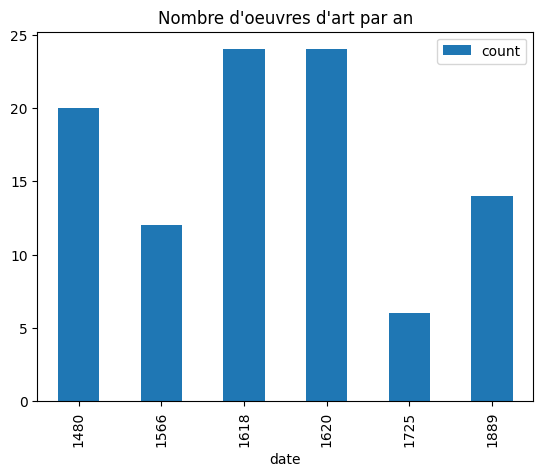

In [17]:
from pandas import json_normalize
import pandas as pd
import json
import matplotlib.pyplot as plot

data = json.load(open("./metadata.json"))
dataframe = json_normalize(data)
grouped = dataframe.groupby("date")["filename"].count().reset_index()
grouped = grouped.rename(columns={"filename": "count"})
grouped.plot(x=0, kind="bar", title="Nombre d'oeuvres d'art par an")

### Nombre d'images pour les différents types : taille de l'image, l'orientation des images, etc.

<Axes: title={'center': "Nombre d'œuvres d'art par taille"}, xlabel='size_str'>

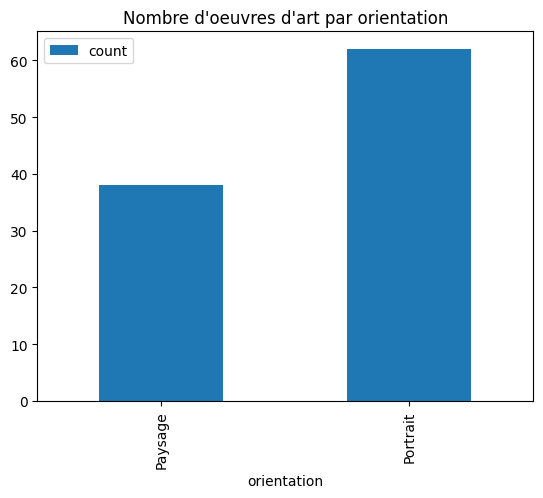

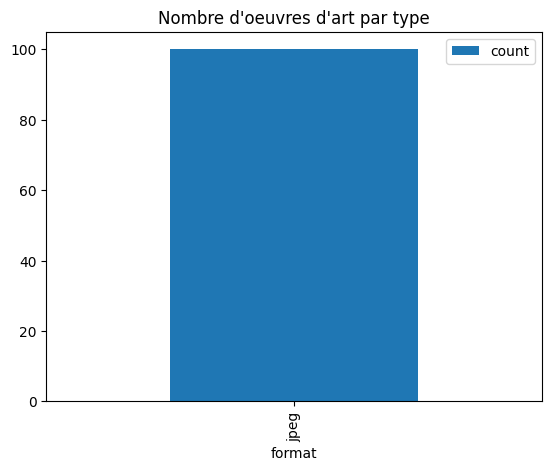

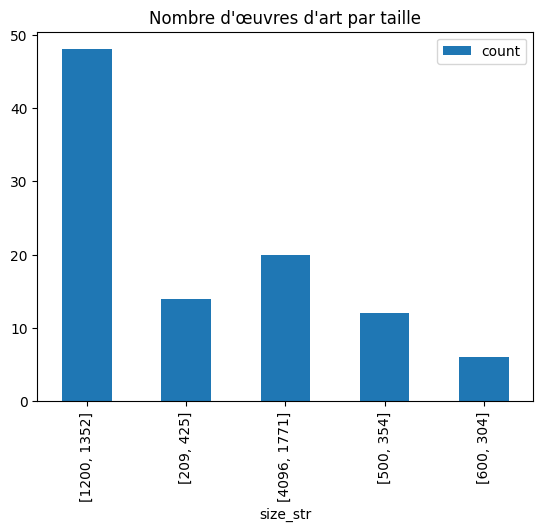

In [24]:
from pandas import json_normalize
import pandas as pd
import json
import matplotlib.pyplot as plot

# Ouverture des métadatas
data = json.load(open("./metadata.json"))
dataframe = json_normalize(data)
# Graphique nombre d'oeuvres d'art par orientation

grouped = dataframe.groupby("orientation")["filename"].count().reset_index()
grouped = grouped.rename(columns={"filename": "count"})
grouped.plot(x=0, kind="bar", title="Nombre d'oeuvres d'art par orientation")

# Graphique nombre d'oeuvres d'art par type
grouped2 = dataframe.groupby("format")["filename"].count().reset_index()
grouped2 = grouped2.rename(columns={"filename": "count"})
grouped2.plot(x=0, kind="bar", title="Nombre d'oeuvres d'art par type")

# Graphique nombre d'oeuvres d'art par taille
dataframe["size_str"] = dataframe["size"].apply(lambda s: str(s))
grouped3 = dataframe.groupby("size_str")["filename"].count().reset_index()
grouped3 = grouped3.rename(columns={"filename": "count"})
grouped3.plot(x="size_str", y="count", kind="bar", title="Nombre d'œuvres d'art par taille")

### Données utilisateurs

In [ ]:
from pandas import json_normalize
import pandas as pd
import json
import matplotlib.pyplot as plot

# Ouverture des métadatas
data = json.load(open("./metadata.json"))
dataframe = json_normalize(data)
# Graphique nombre d'oeuvres d'art par orientation

grouped = dataframe.groupby("orientation")["filename"].count().reset_index()
grouped = grouped.rename(columns={"filename": "count"})
grouped.plot(x=0, kind="bar", title="Nombre d'oeuvres d'art par orientation")

# Graphique nombre d'oeuvres d'art par type
grouped2 = dataframe.groupby("format")["filename"].count().reset_index()
grouped2 = grouped2.rename(columns={"filename": "count"})
grouped2.plot(x=0, kind="bar", title="Nombre d'oeuvres d'art par type")

# Graphique nombre d'oeuvres d'art par taille
dataframe["size_str"] = dataframe["size"].apply(lambda s: str(s))
grouped3 = dataframe.groupby("size_str")["filename"].count().reset_index()
grouped3 = grouped3.rename(columns={"filename": "count"})
grouped3.plot(x="size_str", y="count", kind="bar", title="Nombre d'œuvres d'art par taille")